In [1]:
import sys
import numpy as np
import pandas as pd
import cv2 
import time
from scipy.signal import butter, lfilter, hann
from numpy import fft
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

In [225]:
def video_data(video):
    cap = cv2.VideoCapture(video)
    #no_of_frames = int(cap.get(7))
    length = int(cap.get(3))
    width = int(cap.get(4))
    no_of_frames = int(cap.get(7))
    fps = cap.get(5) #frame rate
    
    y = np.zeros(no_of_frames)
    
    #vreme pojavljivanja svakog frejma
    time_list=[]
    t=0

    start = time.time()
    df = fps * 0.001
    print df
    difference = 1.0 / df 
    for i in range(no_of_frames):
        ret,frame = cap.read()
        #length,width,channels = frame.shape
        #prosecna "red value" frejma
        y[i] = np.sum(frame[:,:,:2])/(length*width)
        
        time_list.append(t)
        t = t + difference
    
    end = time.time()
    secs = end - start
    #fps = no_of_frames / secs
    cap.release()
    #ukupna duzina tajmera podeljena sa poslednjim unetim vremenom;
    #mnozi se sa 1000 da bi se dobila Hz vrednost
    fs = (len(time_list) / time_list[-1]) * 1000
    print no_of_frames
    
    return y, fps, time_list

In [200]:
f, fps, times = video_data('Z.mp4')

0.0295093908908
794


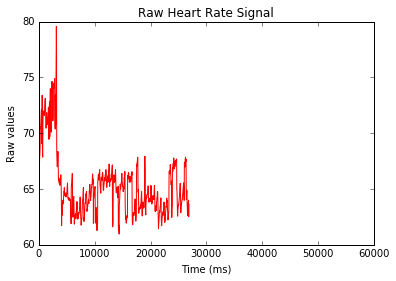

In [201]:
plt.title("Raw Heart Rate Signal")
plt.xlim(0, 60000)
plt.plot(times, f, 'r')
plt.xlabel('Time (ms)')
plt.ylabel('Raw values')

In [234]:
#racuna prosek pomeraja
def rolmean(f, hrw, fs):
    mov_avg = pd.rolling_mean(f, window = int(hrw * fs))
    avg_hr = (np.mean(f))
    mov_avg = [avg_hr if np.isnan(x) else x for x in mov_avg]
    #mov_avg = [x * 1.2 for x in mov_avg]
    return mov_avg

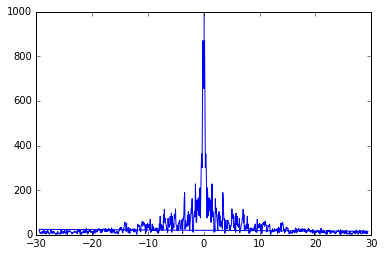

In [235]:
#fs = 2 * 1.67; do 1.67Hz je otkucaj srca, 100bpm (100/60)
c = fft.fft(f)
fs = fps * 2
#fs = 100.0
freq_res = fs / len(c)
samples = int(fs / freq_res)
time_sampling = samples / fs #period uzorkovanja u s


freq = fft.fftfreq(samples, 1.0/fs)
plt.ylim(0, 1000)
plt.plot(freq, np.abs(c))

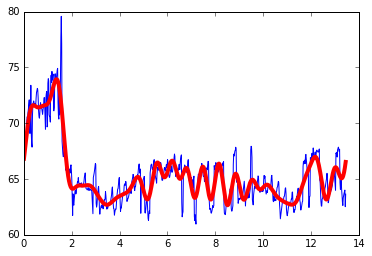

In [236]:
#eliminisemo sve one koje su manje od 1.67, tj manje od 40bpm (100/60 ~ 1.67)
c_filtered = c * (np.abs(freq)<1.67)
f_filtered = fft.ifft(c_filtered)

t = np.linspace(0, time_sampling, samples, endpoint = True)
plt.plot(t, f, 'b-')
plt.plot(t, f_filtered.real, 'r-', lw=4)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


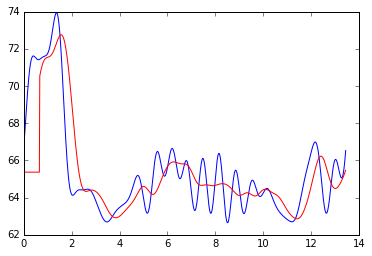

In [237]:
#velicina "moving window"-a, potrebna sa racunanje "moving average"
w = (max(f_filtered.real) - 0.5 * (max(f_filtered.real) - min(f_filtered.real))) / 100
movavg = rolmean(f_filtered.real, w, fs)

plt.plot(t, f_filtered.real, 'b-')
plt.plot(t, movavg, 'r-')
plt.show()

In [238]:
#da eliminisemo sve male vrednosti
m = np.mean(movavg)
mm = []
for i in range (0, len(movavg)):
    if movavg[i] >= m:
        mm.append(movavg[i])

In [243]:
#fja za detekciju peak-ova, preuzeta sa interneta
def peak_detection(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [244]:
indices = peak_detection(mm)
indices

array([ 92, 161, 185, 226])

In [245]:
def calc_RR(f, fs, peaks):
    RR = []
    cnt = 0
    while (cnt < (len(peaks) - 1)):
        RR_int = (peaks[cnt+1] - peaks[cnt]) #rast u ms 
        #ms_dist = ((RR_int / fs) * 1000) # 1ms = 1000Hz
        RR.append(RR_int)
        cnt += 1
    return RR

def calc_bpm(RR):
    bpm = np.mean(RR)
    return bpm



In [246]:
RR = calc_RR(mm, fs, indices)
bpm = calc_bpm(RR)

In [247]:
print "Otkucaj srca je: %01f bpm:" %bpm


Otkucaj srca je: 44.666667 bpm:


In [248]:
ybeat = [mm[x] for x in indices]
len(ybeat)

4

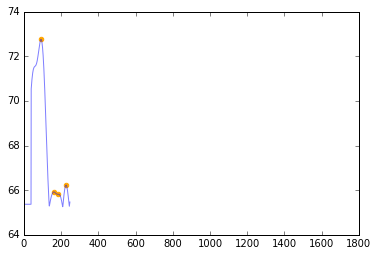

In [249]:
plt.xlim(0, 1800)
#plt.plot(f, 'r', alpha = 0.5)
plt.plot(mm, 'b', alpha = 0.5)
plt.scatter(indices, ybeat, color = 'orange')